In [1]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

import coreset

In [2]:
data_vectors = np.load('Datasets/catdog_data_vectors.npy')
vector_to_label = np.load('Datasets/catdog_vector_to_label.npy', allow_pickle=True).item()

In [37]:
data_vectors = np.array(list(np.abs(np.random.normal(loc=np.ones(512), scale=np.random.uniform(low=0, high=0.05, size=512), size=(500, 512))))
 +list(np.abs(np.random.normal(loc=0.5*np.ones(512), scale=np.random.uniform(low=0, high=0.1, size=512), size=(1500, 512))))
 +list(np.abs(np.random.normal(loc=np.zeros(512), scale=np.random.uniform(low=0, high=0.3, size=512), size=(8000, 512)))))
np.random.shuffle(data_vectors)

In [8]:
new_data_vectors = []
for data_vector in data_vectors:
    if 'Cat' not in vector_to_label[data_vector.tobytes()]:
        new_data_vectors.append(data_vector)
data_vectors = new_data_vectors

In [22]:
def kmeans_cost(data_vectors, coreset_vectors, sample_weight=None):
    kmeans = KMeans(n_clusters=2).fit(coreset_vectors, sample_weight=sample_weight)
    return coreset.get_cost(data_vectors, kmeans.cluster_centers_)

In [23]:
bestB, bestB_cost = None, np.inf

# pick B with least error from 10 runs
for _ in range(10):
    B = coreset.Algorithm1(data_vectors, k=2)
    cost = coreset.get_cost(data_vectors, B)
    if cost < bestB_cost:
        bestB, bestB_cost = B, cost
        
B = bestB

In [24]:
cost_kmeansplusplus_init = kmeans_cost(data_vectors, coreset_vectors=B)

In [28]:
cost_whole = kmeans_cost(data_vectors, coreset_vectors=data_vectors)

random_sample_10 = [data_vectors[i] for i in np.random.choice(len(data_vectors), size=10)]
random_sample_20 = [data_vectors[i] for i in np.random.choice(len(data_vectors), size=20)]
random_sample_40 = [data_vectors[i] for i in np.random.choice(len(data_vectors), size=40)]

cost_10_random = kmeans_cost(data_vectors, coreset_vectors=random_sample_10)
cost_20_random = kmeans_cost(data_vectors, coreset_vectors=random_sample_20)
cost_40_random = kmeans_cost(data_vectors, coreset_vectors=random_sample_40)

In [37]:
coreset_vectors_10, coreset_weights_10 = coreset.Algorithm2(data_vectors, k=2, B=B, m=10)
coreset_vectors_20, coreset_weights_20 = coreset.Algorithm2(data_vectors, k=2, B=B, m=20)
coreset_vectors_40, coreset_weights_40 = coreset.Algorithm2(data_vectors, k=2, B=B, m=40)

cost_10_coreset = kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_10, sample_weight=coreset_weights_10)
cost_20_coreset = kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_20, sample_weight=coreset_weights_20)
cost_40_coreset = kmeans_cost(data_vectors, coreset_vectors=coreset_vectors_40, sample_weight=coreset_weights_40)

In [42]:
import itertools

def brute_force_optimize(coreset_vectors, coreset_weights, data_vectors):
    best_cost = np.inf
    
    m = len(coreset_vectors)
    for bits in itertools.product([-1, 1], repeat=m):
        if -1 not in bits or 1 not in bits:
            # skip assignments that only have one cluster
            continue
        
        minus1_center, plus1_center = np.zeros_like(coreset_vectors[0]), np.zeros_like(coreset_vectors[0])
        minus1_weight, plus1_weight = 0, 0
        
        for bit, v, w in zip(bits, coreset_vectors, coreset_weights):
            if bit == -1:
                minus1_center += w * v; minus1_weight += w
            elif bit == 1:
                plus1_center += w * v; plus1_weight += w
        
        minus1_center /= minus1_weight
        plus1_center /= plus1_weight
        
        cost = coreset.get_cost(data_vectors, [minus1_center, plus1_center])
        if cost < best_cost:
            best_cost = cost
            print(best_cost)
    
    return best_cost

In [43]:
brute_force_optimize(coreset_vectors_10, coreset_weights_10, data_vectors)

3061106.586597426
3029393.2656288743
3019845.72742035
3014798.6153979595


3014798.6153979595

(1693028.5656158756, 4712355.631867724)

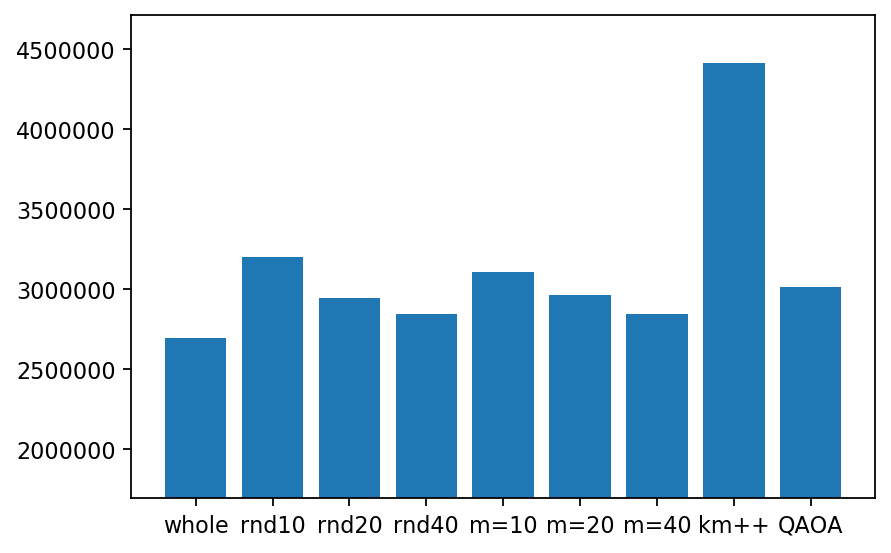

In [45]:
plt.figure(num=None, figsize=(6, 4), dpi=160, facecolor='w', edgecolor='k')
x = np.arange(9)
costs = [cost_whole, cost_10_random, cost_20_random, cost_40_random, cost_10_coreset, cost_20_coreset, cost_40_coreset, cost_kmeansplusplus_init, 3014798.6153979595]
labels = ['whole', 'rnd10', 'rnd20', 'rnd40', 'm=10', 'm=20', 'm=40', 'km++', 'QAOA']
plt.bar(x, costs, tick_label=labels)

plt.ylim(min(costs)-1000000, max(costs) + 300000)
#plt.ylim([5683501.820666957-100000, 5683501.820666957+100000])

# fig, ax = plt.subplots()
# labels = ['', 'whole', 'm=10', 'm=20', 'm=40', 'km++', 'rand 10', 'rand 20', 'rand 40']
# ax.set_xticklabels(labels, rotation=90)
# plt.bar(x, costs)
# ax.set_ylim([min(costs)-100, max(costs)+100])
# plt.show()

In [39]:
cost_10_coreset

3108655.6359984204